This will provide model creation on facial recognization & identification of specific features


#Import Libraries/Dataset

*   **Download the dataset:** Data from Google Drive of CelebA was downloaded and extracted. After extraction it was uploaded to Google Drive under \CelebA Directory
*   **Import the required libraries:** 

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#List the content (Access the google drive)
!ls "/content/gdrive/MyDrive/CelebA"
!ls "/content/gdrive/MyDrive/CelebA/Anno"

Anno  Eval  Img
celeb_attributes_2000.csv  list_bbox_celeba.txt
celeb_attributes.csv	   list_landmarks_align_celeba.txt
identity_CelebA.txt	   list_landmarks_align_celeba_v1.csv
list_attr_celeba.txt	   list_landmarks_celeba.txt


**Import Libraries**
We imported tensorflow & karas related libraries to process images. 

In [ ]:
## Following libraries will be uploaded to process the data and build model. 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches


Since images can be of different size and some can be very large, we need to resize them to ensure that they are not very large and are also able to meet the requirements of this assignment. 

In [ ]:
## Defining the path to the datasets
key_points_data_path = "/content/gdrive/MyDrive/CelebA/Anno/celeb_attributes.csv"
images_data_path = "/content/gdrive/MyDrive/CelebA/Img"

# Since, the dataset is very huge. Hence, we will only select 500 images for testing. We
# executed model with large number of dataset but it was taking significant amount of time for the executon and training. 
images_data_size = 500

# Original image dimensions
x_org = 178    # original x value
y_org = 218    # original y value

#Let's scale the images to new dimensions

# New image dimensions
x_ = 100                            # new value of x
image_size_ratio = x_org / y_org    # dimensions ratio
y_ = int(image_size_ratio * x_)     # new value of y

# Image Sizes
original_image_size = (x_org, y_org)
new_image_size = (x_,y_)

# The image size that will be used in the training process
image_size_training = new_image_size


Read the CSV file. For simplicity we have reduced the size of the data to ensure that we are able to run and test this otherwise due to large number of images this may take significant amount of time to run this assignment.

However, in production environment this has to run with large dataset

In [ ]:
# load the dataset (key points)
df_org = pd.read_csv(key_points_data_path) # read the entire CSV but trim as per the data size
df_org = df_org[:images_data_size]
df_org.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
df_org.head(5)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
df_org.shape

(500, 41)

Perform one-hot encoding so that we know which image is classified in which way. Hence, replace -1 with zero. 

#Data Visualization and Exploration
**Data Pre-processing and cleaning** ,
**Preparing the data for our Deep Learning**

In [ ]:
df_org = df_org.replace(-1, 0) # One hot encoding. This will replace -1 with zero
df_org.head(5)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
import seaborn as sns

# This function returns attr names using in dataset.
def get_attr_names(dataframe):
    attr_names = []
    attr_names = list(dataframe.columns)
    # removing images_id column
    del attr_names[0]
    return attr_names

def plot_attr(attr_names):
    f = plt.figure(figsize=(20, 15))
    for i, attr_name in enumerate(attr_names):
        f.add_subplot(4, 10, i+1)
        col = df_org[attr_name]
        g = sns.barplot(x=col.value_counts().index, y=col.value_counts(normalize=True))
        g.set(ylim=(0, 1))
        plt.yticks([])
    plt.show()

Plot the values of each attribute. This will help us to find out the distribution of values across all attributes. If there is only single attribute for all images or if there are very high number of values of single attribute then we need to omit the attribute from the analysis as this will not give proper result. For e.g. wearing hat or having mustache are skewed and we have omitted from analysis.

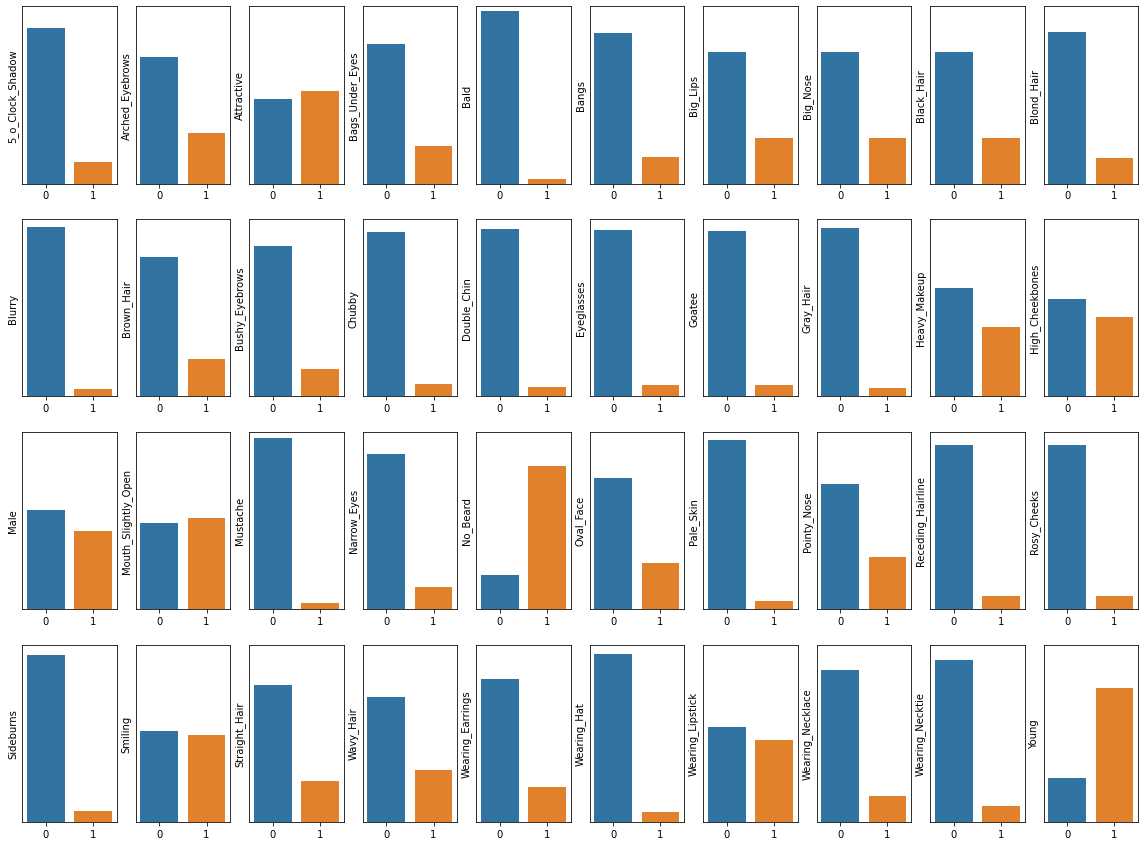

In [ ]:
attr_names = get_attr_names(df_org)
plot_attr(attr_names)

Also, find out the percentage distirbution of values. This will give percentage of values present. This is similar to finding the score of features but in our case its lable. 

In [ ]:
# This will help us to find out how many labels are very common. We can omit these lables. 

sum = (df_org.drop("image_id", axis=1).sum(axis=0))*100/255
sumarray = sum.array
sum

5_o_Clock_Shadow        24.313725
Arched_Eyebrows         56.078431
Attractive             102.745098
Bags_Under_Eyes         41.568627
Bald                     5.098039
Bangs                   29.803922
Big_Lips                50.196078
Big_Nose                50.196078
Black_Hair              50.196078
Blond_Hair              27.843137
Blurry                   8.235294
Brown_Hair              41.568627
Bushy_Eyebrows          30.196078
Chubby                  14.117647
Double_Chin             10.588235
Eyeglasses              12.156863
Goatee                  12.941176
Gray_Hair                9.803922
Heavy_Makeup            76.470588
High_Cheekbones         87.843137
Male                    86.666667
Mouth_Slightly_Open    100.784314
Mustache                 6.666667
Narrow_Eyes             24.313725
No_Beard               158.039216
Oval_Face               51.372549
Pale_Skin                9.411765
Pointy_Nose             57.254902
Receding_Hairline       14.509804
Rosy_Cheeks   

**Create Array of images**

Convert the images in 2D array. 

In [ ]:
images_data = list()
for idx in range(df_org.shape[0]):
    # Retrieving the path based upon the index
    path = "{}/{}".format(str(images_data_path),str(df_org.iloc[idx].image_id))
    
    # Reading images using PIL library
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255
    
    # Appending the images to a list
    images_data.append(image_array)

len(images_data)



500

In [ ]:
# Converting images_data to an array from list
images_data = np.array(images_data)
images_data.shape

(500, 81, 100, 3)

**Display a sample image**

22


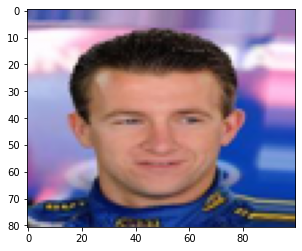

In [ ]:
import random

# Plotting a sample image
randomImage = random.randint(0, images_data_size)
print(randomImage)
plt.imshow(images_data[randomImage])

In [ ]:
print("Images Data Arrays Shape:", images_data.shape)
print("Key Points Data Shape:", df_org.shape)

Images Data Arrays Shape: (500, 81, 100, 3)
Key Points Data Shape: (500, 41)


In [ ]:
df_org.isnull().sum() # Lets find out any missing values. Since the sum is all zero there are no missing values. 

image_id               0
5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0


In [ ]:
df_org.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.0000,500.00000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,0.124000,0.286000,0.524000,0.212000,0.026000,0.15200,0.256000,0.256000,0.256000,0.1420,0.04200,0.212000,0.15400,0.072000,0.054000,0.062000,0.066000,0.050000,0.390000,0.448000,0.442000,0.514000,0.034000,0.124000,0.806000,0.262000,0.04800,0.292000,0.074000,0.076000,0.060000,0.490000,0.228000,0.294000,0.194000,0.054000,0.464000,0.14600,0.088000,0.752000
std,0.329912,0.452342,0.499924,0.409134,0.159295,0.35938,0.436859,0.436859,0.436859,0.3494,0.20079,0.409134,0.36131,0.258747,0.226244,0.241397,0.248531,0.218163,0.488238,0.497787,0.497122,0.500305,0.181411,0.329912,0.395825,0.440163,0.21398,0.455138,0.262033,0.265264,0.237725,0.500401,0.419963,0.456048,0.395825,0.226244,0.499202,0.35346,0.283579,0.432284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


**Reading Images Function**

This functions is for converting images to arrays to deal with it in the model.


In [ ]:
# function to read images based on index (image number passed)
def image_array(index, size=image_size_training, path=images_data_path):
    # to get the path based on index
    path = "{}/{}".format(str(path),str(df_org.iloc[index].image_id))
    
    # to read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    
    return image_array

This function for getting the key points on the face as list to deal with it in plotting sections



In [ ]:
# function to get a list of all key points of the face
def image_key_points_list(index, df = df_org):
    # box dictionary
    points_list = [df.iloc[index].Attractive,
                   df.iloc[index].Heavy_Makeup,
                   df.iloc[index].Smiling,
                   df.iloc[index].Straight_Hair,
                   df.iloc[index].Blond_Hair,
                   df.iloc[index].Bags_Under_Eyes,
                   df.iloc[index].Male,
                   df.iloc[index].Wearing_Lipstick,
                   df.iloc[index].Big_Nose,
                   df.iloc[index].Big_Lips, 
                   df.iloc[index].No_Beard, 
                   df.iloc[index].Mouth_Slightly_Open, 
                   df.iloc[index].Young, 
                   df.iloc[index].High_Cheekbones, 
                   df.iloc[index].Wavy_Hair, 
                   df.iloc[index].Pointy_Nose, 
                   df.iloc[index].Black_Hair
                   ]
    
    return points_list

This function for getting the key attributes on the face as list


In [ ]:
# function to get a list of all key attributes of the face
def image_key_attributes_name():
    # Attributes dictionary
    attr_list = ['Attractive',
                   'Heavy_Makeup',
                   'Smiling',
                   'Straight_Hair',
                   'Blond_Hair',
                   'Bags_Under_Eyes',
                   'Male',
                   'Wearing_Lipstick',
                   'Big_Nose',
                   'Big_Lips', 
                   'No_Beard', 
                   'Mouth_Slightly_Open', 
                   'Young', 
                   'High_Cheekbones', 
                   'Wavy_Hair', 
                   'Pointy_Nose', 
                   'Black_Hair']
    
    return attr_list

oAttributes_list = image_key_attributes_name()
no_attributes = len(oAttributes_list)
print(no_attributes)

17


Now get only selected attributes of images based on distribution of the attributes and percentages of attributes. 

In [ ]:
# Get only selected attributes
df_new = df_org[["Attractive", "Heavy_Makeup", "Smiling", "Straight_Hair", "Blond_Hair", "Bags_Under_Eyes", "Male", "Wearing_Lipstick", "Big_Nose", "Big_Lips", 'No_Beard', "Mouth_Slightly_Open", "Young", "High_Cheekbones", "Wavy_Hair", "Pointy_Nose", "Black_Hair"]]
df_new.head(5)


,Attractive,Heavy_Makeup,Smiling,Straight_Hair,Blond_Hair,Bags_Under_Eyes,Male,Wearing_Lipstick,Big_Nose,Big_Lips,No_Beard,Mouth_Slightly_Open,Young,High_Cheekbones,Wavy_Hair,Pointy_Nose,Black_Hair
0,1,1,1,1,0,0,0,1,0,0,1,1,1,1,0,1,0
1,0,0,1,0,0,1,0,0,1,0,1,1,1,1,0,0,0
2,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0
3,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
4,1,1,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0


Function to display the image & its attributes


In [ ]:
def display_image_attributes(index, df = df_org, size=original_image_size, displayImage = True):

    points_list = image_key_points_list(index, df)
    attr_list = image_key_attributes_name()
        
    # plot the image
    if displayImage == True:
      # Create figure and axes
      fig, ax = plt.subplots()
      test_image = image_array(index, size)
      ax.imshow(test_image)

    iAttr = 0
    imageAttrs = list()
    for  attribute1 in points_list:
      if attribute1 == 1:
        imageAttrs.append(oAttributes_list[iAttr])
      iAttr = iAttr + 1
    
    return imageAttrs
      

['Smiling',
 'Male',
 'Big_Nose',
 'Big_Lips',
 'Mouth_Slightly_Open',
 'Young',
 'High_Cheekbones',
 'Black_Hair']

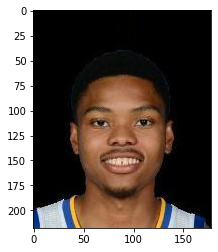

In [ ]:
# Display Image attributes
display_image_attributes(random.randint(1, images_data_size))

In [ ]:
# copy a version from the data to prepare it for analysis
df = df_new.copy()

# check
df.head(5)

,Attractive,Heavy_Makeup,Smiling,Straight_Hair,Blond_Hair,Bags_Under_Eyes,Male,Wearing_Lipstick,Big_Nose,Big_Lips,No_Beard,Mouth_Slightly_Open,Young,High_Cheekbones,Wavy_Hair,Pointy_Nose,Black_Hair
0,1,1,1,1,0,0,0,1,0,0,1,1,1,1,0,1,0
1,0,0,1,0,0,1,0,0,1,0,1,1,1,1,0,0,0
2,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0
3,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
4,1,1,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0


In [ ]:
images=images_data
labels=df

# Train / Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_images,test_images,train_labels,test_labels=train_test_split(images,labels,
                                                                  test_size=0.3,random_state=42)

In [ ]:
y_test=test_labels
y_train=train_labels

X_test=test_images
X_train=train_images

In [ ]:
## Further splitting the test data into validation and test data
X_test, X_val, y_test, y_val=train_test_split(X_test, y_test,
                                              test_size=0.5,random_state=42)

In [ ]:
y_test.head(3)


,Attractive,Heavy_Makeup,Smiling,Straight_Hair,Blond_Hair,Bags_Under_Eyes,Male,Wearing_Lipstick,Big_Nose,Big_Lips,No_Beard,Mouth_Slightly_Open,Young,High_Cheekbones,Wavy_Hair,Pointy_Nose,Black_Hair
321,1,1,1,0,1,0,0,1,0,1,1,1,1,1,0,1,0
261,1,1,1,0,0,0,0,1,0,1,1,1,1,1,1,1,1
410,1,1,1,0,0,0,0,1,0,0,1,1,1,1,1,1,0


In [ ]:
y_val.head(3)

,Attractive,Heavy_Makeup,Smiling,Straight_Hair,Blond_Hair,Bags_Under_Eyes,Male,Wearing_Lipstick,Big_Nose,Big_Lips,No_Beard,Mouth_Slightly_Open,Young,High_Cheekbones,Wavy_Hair,Pointy_Nose,Black_Hair
290,0,1,0,0,1,1,0,1,0,0,1,0,0,1,1,0,0
316,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,0,0
117,1,1,1,0,0,0,0,1,0,0,1,0,1,1,0,1,1


# MobileNetV2 Model

In next few section we will try three different models. We will identify false positive, false negative, true negative, true positives etc. This will help us to find out which model is able to predict better. 

Please note, the accuracy of model will improve based on number of training data. 

In [ ]:
# This is addition of new code as Seuqential model is not giving results as expected. 
from keras.models import Model 
from keras.layers import Dropout, Dense, BatchNormalization
from keras.applications.mobilenet_v2 import MobileNetV2

x__ = image_size_training[0]
y__ = image_size_training[1]

base = MobileNetV2(input_shape=(y__, x__, 3),
                    weights=None,
                    include_top=False,
                    pooling='avg')  # GlobalAveragePooling 2D

# model top
x = base.output
x = Dense(1536, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
top = Dense(no_attributes, activation='sigmoid')(x)

modelv01=Model(inputs=base.input, outputs=top)
modelv01.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 81, 100, 3)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 41, 50, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 41, 50, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 41, 50, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
modelv01.compile(optimizer="rmsprop", loss='mean_squared_error',metrics=["mae",
                                                                         tf.keras.metrics.TruePositives(), 
                                                                         tf.keras.metrics.TrueNegatives(),
                                                                         tf.keras.metrics.FalsePositives(), 
                                                                         tf.keras.metrics.FalseNegatives(),
                                                                         tf.keras.metrics.PrecisionAtRecall(0.5),
                                                                         tf.keras.metrics.Accuracy()])


# Sequential Model

In [ ]:
# Build Sequential model
x_ = image_size_training[0]
y_ = image_size_training[1]

# build the model
model = Sequential()
model.add(Dense(64, activation='relu',input_shape=(y_,x_,3)))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu',input_shape=(y_,x_,3)))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu',input_shape=(y_,x_,3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(no_attributes, activation='sigmoid'))


In [ ]:
## Having a quick view of the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 81, 100, 64)       256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 81, 100, 64)       0         
_________________________________________________________________
dense_13 (Dense)             (None, 81, 100, 32)       2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 81, 100, 32)       0         
_________________________________________________________________
dense_14 (Dense)             (None, 81, 100, 16)       528       
_________________________________________________________________
dropout_14 (Dropout)         (None, 81, 100, 16)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 129600)           

In [ ]:
model.compile(optimizer="rmsprop", loss='mean_squared_error',metrics=["mae", 
                                                                      tf.keras.metrics.TruePositives(), 
                                                                      tf.keras.metrics.TrueNegatives(), 
                                                                      tf.keras.metrics.FalsePositives(), 
                                                                      tf.keras.metrics.FalseNegatives(), 
                                                                      tf.keras.metrics.PrecisionAtRecall(0.5), 
                                                                      tf.keras.metrics.Accuracy()])
#model.compile(optimizer="adam", loss='binary_crossentropy',metrics=["binary_accuracy"])


# CNN Model

In [ ]:
modelCNN = Sequential()

modelCNN.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation="relu", input_shape=(y_,x_,3)))
modelCNN.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=2))
modelCNN.add(Dropout(0.2))

modelCNN.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
modelCNN.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=2))
modelCNN.add(Dropout(0.2))

modelCNN.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
modelCNN.add(MaxPooling2D(pool_size=2))
modelCNN.add(Dropout(0.2))

modelCNN.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=2))
modelCNN.add(Dropout(0.2))
modelCNN.add(Flatten())

modelCNN.add(Dense(64, activation='relu'))
modelCNN.add(Dropout(0.2))

modelCNN.add(Dense(32, activation='relu'))
modelCNN.add(Dropout(0.2))

modelCNN.add(Dense(16, activation='relu'))
modelCNN.add(Dropout(0.2))

modelCNN.add(Dense(no_attributes, activation='sigmoid'))  # Output Layer. Ideally reduce number of outputs


In [ ]:
modelCNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 81, 100, 8)        224       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 81, 100, 8)        584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 50, 8)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 40, 50, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 50, 16)        1168      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 50, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 25, 16)       

In [ ]:
modelCNN.compile(optimizer="rmsprop", loss='mean_squared_error',metrics=["mae"
                                                                         ,tf.keras.metrics.TruePositives() 
                                                                         ,tf.keras.metrics.TrueNegatives() 
                                                                         ,tf.keras.metrics.FalsePositives() 
                                                                         ,tf.keras.metrics.FalseNegatives() 
                                                                         ,tf.keras.metrics.PrecisionAtRecall(0.5) 
                                                                         ,tf.keras.metrics.Accuracy()
                                                                         ])

# Model Training

In few lines we will train the models. We have selected EPOCHs, batch size etc after multiple tries. This will help us to get best EPOCH and batch size. 

**Training of Sequential Model**

In [ ]:
# fitting the model with our data & this is for sequential model
training_process = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=20, shuffle=True)

Epoch 1/10
18/18 [==============================] - 9s 398ms/step - loss: 0.2432 - mae: 0.3840 - true_positives_4: 970.0000 - true_negatives_4: 2942.0000 - false_positives_4: 690.0000 - false_negatives_4: 1348.0000 - precision_at_recall_4: 0.5530 - accuracy: 0.0037 - val_loss: 0.2483 - val_mae: 0.4982 - val_true_positives_4: 212.0000 - val_true_negatives_4: 560.0000 - val_false_positives_4: 188.0000 - val_false_negatives_4: 315.0000 - val_precision_at_recall_4: 0.4448 - val_accuracy: 0.0000e+00
Epoch 2/10
18/18 [==============================] - 6s 357ms/step - loss: 0.1994 - mae: 0.3944 - true_positives_4: 1115.0000 - true_negatives_4: 3111.0000 - false_positives_4: 521.0000 - false_negatives_4: 1203.0000 - precision_at_recall_4: 0.6697 - accuracy: 0.0000e+00 - val_loss: 0.2322 - val_mae: 0.4726 - val_true_positives_4: 252.0000 - val_true_negatives_4: 535.0000 - val_false_positives_4: 213.0000 - val_false_negatives_4: 275.0000 - val_precision_at_recall_4: 0.5486 - val_accuracy: 0.0000

In [ ]:
## Testing the model
### Evaluating the model performance on the basis of 
perf_values_seq = model.evaluate(X_test, y_test)
print("True Positive", perf_values_seq[2]) 
print("True Negatives", perf_values_seq[3]) 
print("false positives", perf_values_seq[4]) 
print("false negatives", perf_values_seq[5]) 
print("Precision", perf_values_seq[6]) 

3/3 [==============================] - 0s 68ms/step - loss: 0.2481 - mae: 0.3879 - true_positives_4: 350.0000 - true_negatives_4: 460.0000 - false_positives_4: 277.0000 - false_negatives_4: 188.0000 - precision_at_recall_4: 0.6413 - accuracy: 0.0000e+00
True Positive 350.0
True Negatives 460.0
false positives 277.0
false negatives 188.0
Precision 0.6413301825523376


**Training of Mobile V2 model**

In [ ]:
training_process_v2 = modelv01.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=4, shuffle=True)


Epoch 1/10
88/88 [==============================] - 32s 251ms/step - loss: 0.2832 - mae: 0.4508 - true_positives_3: 1106.0000 - true_negatives_3: 2380.0000 - false_positives_3: 1252.0000 - false_negatives_3: 1212.0000 - precision_at_recall_3: 0.4649 - accuracy: 0.0000e+00 - val_loss: 0.2321 - val_mae: 0.4104 - val_true_positives_3: 152.0000 - val_true_negatives_3: 675.0000 - val_false_positives_3: 73.0000 - val_false_negatives_3: 375.0000 - val_precision_at_recall_3: 0.5333 - val_accuracy: 0.0000e+00
Epoch 2/10
88/88 [==============================] - 21s 236ms/step - loss: 0.2439 - mae: 0.4009 - true_positives_3: 963.0000 - true_negatives_3: 2853.0000 - false_positives_3: 779.0000 - false_negatives_3: 1355.0000 - precision_at_recall_3: 0.5314 - accuracy: 0.0000e+00 - val_loss: 0.2261 - val_mae: 0.3935 - val_true_positives_3: 200.0000 - val_true_negatives_3: 648.0000 - val_false_positives_3: 100.0000 - val_false_negatives_3: 327.0000 - val_precision_at_recall_3: 0.6133 - val_accuracy: 

In [ ]:
perf_values_modelv2 = modelv01.evaluate(X_test, y_test)
print("True Positive", perf_values_modelv2[2]) 
print("True Negatives", perf_values_modelv2[3]) 
print("false positives", perf_values_modelv2[4]) 
print("false negatives", perf_values_modelv2[5]) 
print("Precision", perf_values_modelv2[6]) 

3/3 [==============================] - 0s 140ms/step - loss: 0.2319 - mae: 0.3946 - true_positives_3: 159.0000 - true_negatives_3: 671.0000 - false_positives_3: 66.0000 - false_negatives_3: 379.0000 - precision_at_recall_3: 0.5486 - accuracy: 0.0000e+00
True Positive 159.0
True Negatives 671.0
false positives 66.0
false negatives 379.0
Precision 0.5485714077949524


**Training of CNN model**


In [ ]:
training_process_cnn = modelCNN.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=4, shuffle=True)

Epoch 1/20
88/88 [==============================] - 8s 70ms/step - loss: 0.2374 - mae: 0.4741 - true_positives_5: 1326.0000 - true_negatives_5: 2189.0000 - false_positives_5: 1443.0000 - false_negatives_5: 992.0000 - precision_at_recall_5: 0.4971 - accuracy: 0.0000e+00 - val_loss: 0.2350 - val_mae: 0.4817 - val_true_positives_5: 222.0000 - val_true_negatives_5: 596.0000 - val_false_positives_5: 152.0000 - val_false_negatives_5: 305.0000 - val_precision_at_recall_5: 0.5480 - val_accuracy: 0.0000e+00
Epoch 2/20
88/88 [==============================] - 6s 64ms/step - loss: 0.2238 - mae: 0.4497 - true_positives_5: 1112.0000 - true_negatives_5: 2700.0000 - false_positives_5: 932.0000 - false_negatives_5: 1206.0000 - precision_at_recall_5: 0.5425 - accuracy: 0.0000e+00 - val_loss: 0.2257 - val_mae: 0.4659 - val_true_positives_5: 222.0000 - val_true_negatives_5: 595.0000 - val_false_positives_5: 153.0000 - val_false_negatives_5: 305.0000 - val_precision_at_recall_5: 0.5694 - val_accuracy: 0.0

In [ ]:
perf_values_cnn = modelCNN.evaluate(X_test, y_test)

print("True Positive", perf_values_cnn[2]) 
print("True Negatives", perf_values_cnn[3]) 
print("false positives", perf_values_cnn[4]) 
print("false negatives", perf_values_cnn[5]) 
print("Precision", perf_values_cnn[6])

3/3 [==============================] - 0s 72ms/step - loss: 0.1833 - mae: 0.3685 - true_positives_5: 303.0000 - true_negatives_5: 640.0000 - false_positives_5: 97.0000 - false_negatives_5: 235.0000 - precision_at_recall_5: 0.7670 - accuracy: 0.0000e+00
True Positive 303.0
True Negatives 640.0
false positives 97.0
false negatives 235.0
Precision 0.7670454382896423


# Model Testing

Testing of Models. Following two functions will print the images and also parameterized to make it general. This will help us to reuse the code. 

In [ ]:
def predictions_test_model(index, modelName):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255

    points_list = ""
    if modelName == "Mobile":
      points_list = modelv01.predict(img.reshape(1,y_,x_,3))[0]
    elif modelName == "Sequential":
      points_list = model.predict(img.reshape(1,y_,x_,3))[0]
    elif modelName == "CNN":
      points_list = modelCNN.predict(img.reshape(1,y_,x_,3))[0]
    
    #print(points_list)
    iPoint = 0
    while iPoint < len(points_list):
      if points_list[iPoint] > 0.5 : 
        points_list[iPoint] = 1
      else:
        points_list[iPoint] = 0
      iPoint = iPoint + 1

    return points_list.astype('int')

In [ ]:
# function to plot the image with green box around the faces
attr_list = image_key_attributes_name()

def model_testing(index, pred_or_actual = 'pred', modelName="Sequential"):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_org,x_org,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255
    
    # predictions of key points on the face
    if pred_or_actual == 'pred':
        points_list = predictions_test_model((index), modelName)        # this for predections of the model
    elif pred_or_actual == 'actual':
        points_list = image_key_points_list(int(index))   # this for the actual labels of the test data

    # Show image and its predicted and actual attributes :)    
    plt.imshow(test_image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    iAttr = 0
    imageAttrs = list()
    for  attribute1 in points_list:
      if attribute1 == 1:
        imageAttrs.append(attr_list[iAttr])
      iAttr = iAttr + 1
    
    print("Predicted Attributes are :", imageAttrs)
    print("Original Attributes are : ", display_image_attributes(int(index), df_org, original_image_size, False))

    return points_list

**Testing of Sequential Model**

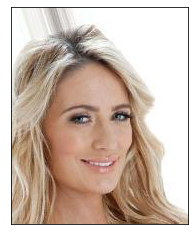

Predicted Attributes are : ['Attractive', 'Heavy_Makeup', 'Blond_Hair', 'Wearing_Lipstick', 'Big_Lips', 'No_Beard', 'Young', 'Wavy_Hair', 'Pointy_Nose']
Original Attributes are :  ['Attractive', 'Smiling', 'Straight_Hair', 'Male', 'Mouth_Slightly_Open', 'Young', 'High_Cheekbones', 'Pointy_Nose', 'Black_Hair']


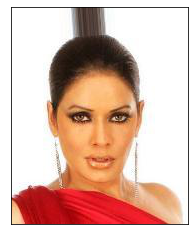

Predicted Attributes are : ['Attractive', 'Heavy_Makeup', 'Blond_Hair', 'Wearing_Lipstick', 'Big_Nose', 'Big_Lips', 'Young', 'Wavy_Hair', 'Pointy_Nose', 'Black_Hair']
Original Attributes are :  ['Heavy_Makeup', 'Smiling', 'Blond_Hair', 'Wearing_Lipstick', 'No_Beard', 'Mouth_Slightly_Open', 'High_Cheekbones', 'Wavy_Hair', 'Pointy_Nose']


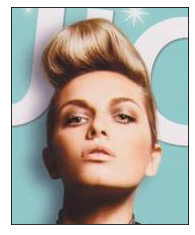

Predicted Attributes are : ['Attractive', 'Heavy_Makeup', 'Blond_Hair', 'Wearing_Lipstick', 'Big_Lips', 'Young', 'Wavy_Hair', 'Pointy_Nose']
Original Attributes are :  ['Attractive', 'Heavy_Makeup', 'Wearing_Lipstick', 'Big_Lips', 'No_Beard', 'Mouth_Slightly_Open', 'Young', 'Wavy_Hair']


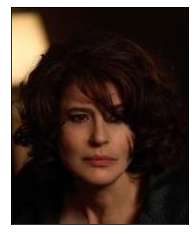

Predicted Attributes are : ['Attractive', 'Wearing_Lipstick', 'No_Beard', 'Young']
Original Attributes are :  ['Attractive', 'Heavy_Makeup', 'Smiling', 'Wearing_Lipstick', 'Big_Lips', 'No_Beard', 'Mouth_Slightly_Open', 'Young', 'High_Cheekbones', 'Wavy_Hair', 'Pointy_Nose', 'Black_Hair']


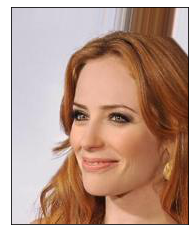

Predicted Attributes are : ['Attractive', 'Heavy_Makeup', 'Blond_Hair', 'Wearing_Lipstick', 'Big_Lips', 'No_Beard', 'Young', 'Wavy_Hair']
Original Attributes are :  ['Attractive', 'Straight_Hair', 'No_Beard', 'Young', 'Pointy_Nose']


In [ ]:
# Using the model to predict a sample image which doesn't exist in train,test, or validation data
iTest = 1
#attr_list = image_key_attributes_name()
while  iTest < 6 :
  index = str(random.randint(1,images_data_size )).zfill(5)
  attributes_list = model_testing(index, pred_or_actual = 'pred', modelName="Sequential")
  iTest = iTest + 1


**Testing of Mobile Model**

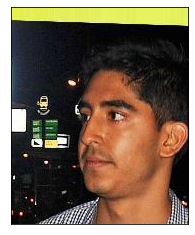

Predicted Attributes are : ['Attractive', 'No_Beard', 'Young']
Original Attributes are :  ['Smiling', 'Bags_Under_Eyes', 'Male', 'No_Beard', 'Mouth_Slightly_Open', 'High_Cheekbones']


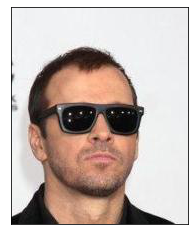

Predicted Attributes are : ['Attractive', 'No_Beard', 'Young']
Original Attributes are :  ['Smiling', 'Bags_Under_Eyes', 'Male', 'Mouth_Slightly_Open', 'Young', 'High_Cheekbones']


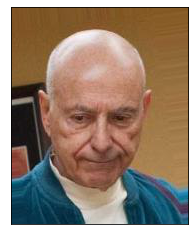

Predicted Attributes are : ['Attractive', 'No_Beard', 'Young']
Original Attributes are :  ['Heavy_Makeup', 'Straight_Hair', 'Blond_Hair', 'Wearing_Lipstick', 'No_Beard', 'Mouth_Slightly_Open', 'Young']


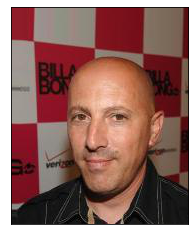

Predicted Attributes are : ['Attractive', 'No_Beard', 'Young']
Original Attributes are :  ['Attractive', 'Bags_Under_Eyes', 'Male', 'No_Beard', 'Young', 'Pointy_Nose', 'Black_Hair']


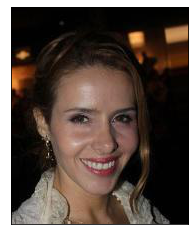

Predicted Attributes are : ['Attractive', 'No_Beard', 'Young']
Original Attributes are :  ['Attractive', 'Heavy_Makeup', 'Smiling', 'Wearing_Lipstick', 'Big_Lips', 'No_Beard', 'Mouth_Slightly_Open', 'Young', 'High_Cheekbones', 'Wavy_Hair', 'Pointy_Nose']


In [ ]:

# Using the model to predict a sample image which doesn't exist in train,test, or validation data
iTest = 1
#attr_list = image_key_attributes_name()
while  iTest < 6 :
  index = str(random.randint(1,images_data_size )).zfill(5)
  attributes_list1 = model_testing(index, pred_or_actual = 'pred', modelName="Mobile")
  iTest = iTest + 1



**Testing of CNN Model**

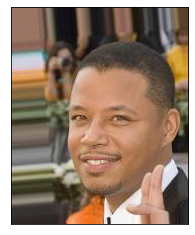

Predicted Attributes are : ['Male', 'No_Beard', 'Young']
Original Attributes are :  ['Attractive', 'Smiling', 'Male', 'Big_Nose']


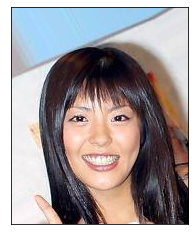

Predicted Attributes are : ['Attractive', 'Heavy_Makeup', 'Smiling', 'Wearing_Lipstick', 'No_Beard', 'Mouth_Slightly_Open', 'Young', 'Wavy_Hair']
Original Attributes are :  ['Attractive', 'Wearing_Lipstick', 'No_Beard', 'Young', 'Pointy_Nose']


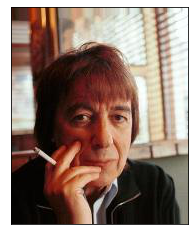

Predicted Attributes are : ['Male', 'No_Beard', 'Young']
Original Attributes are :  ['Smiling', 'Bags_Under_Eyes', 'Male', 'Big_Nose', 'No_Beard', 'Mouth_Slightly_Open', 'High_Cheekbones']


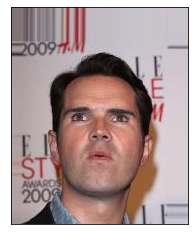

Predicted Attributes are : ['Attractive', 'No_Beard', 'Young']
Original Attributes are :  ['Smiling', 'Straight_Hair', 'Male', 'No_Beard', 'Mouth_Slightly_Open', 'Young', 'High_Cheekbones', 'Black_Hair']


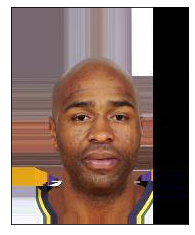

Predicted Attributes are : ['Male', 'No_Beard', 'Young']
Original Attributes are :  ['Attractive', 'Smiling', 'Straight_Hair', 'Bags_Under_Eyes', 'Wearing_Lipstick', 'Big_Nose', 'No_Beard', 'Mouth_Slightly_Open', 'Young', 'High_Cheekbones']


In [ ]:
# Using the model to predict a sample image which doesn't exist in train,test, or validation data
iTest = 1
#attr_list = image_key_attributes_name()
while  iTest < 6 :
  index = str(random.randint(1,images_data_size )).zfill(5)
  attributes_list = model_testing(index, pred_or_actual = 'pred', modelName="CNN")
  iTest = iTest + 1


#Model Comparisons & Performance Evaluation

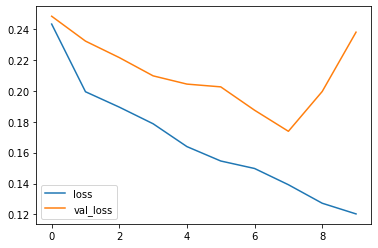

In [ ]:
# Sequential Model

# losses of both training and validation sets
loss = training_process.history['loss']
val_loss = training_process.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

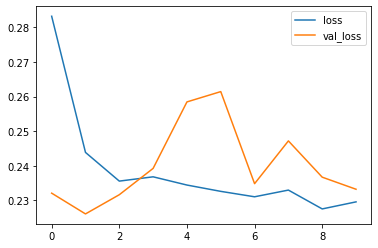

In [ ]:
# Mobile V2 Model

# losses of both training and validation sets
loss = training_process_v2.history['loss']
val_loss = training_process_v2.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

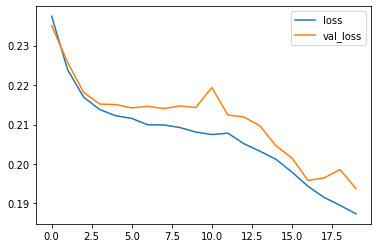

In [ ]:
# CNN Model

# losses of both training and validation sets
loss = training_process_cnn.history['loss']
val_loss = training_process_cnn.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

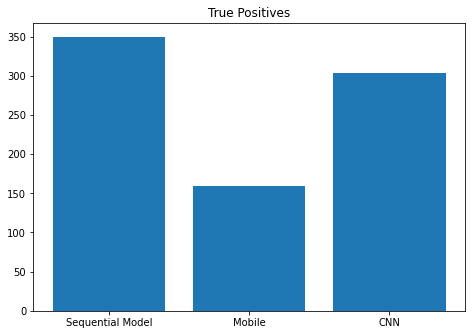

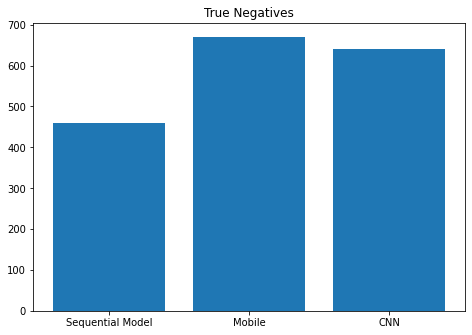

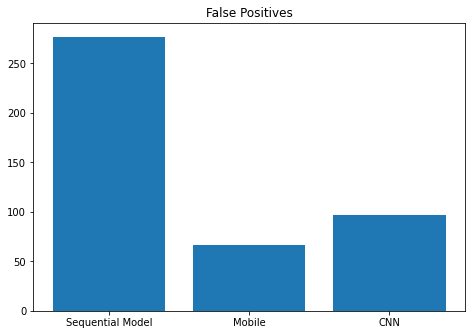

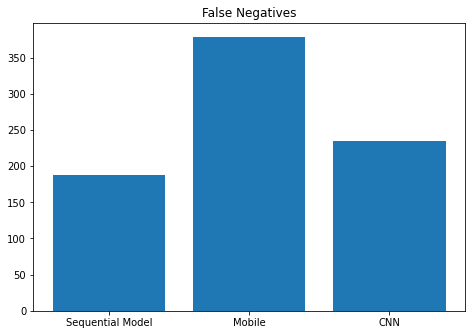

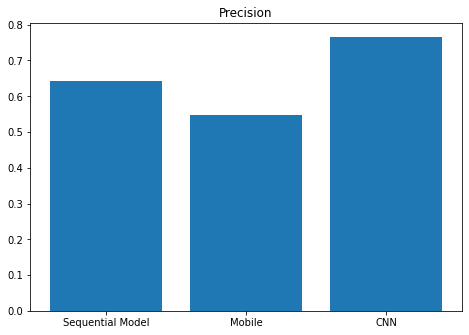

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Sequential Model', 'Mobile', 'CNN']
values = [perf_values_seq[2],perf_values_modelv2[2],perf_values_cnn[2]]
ax.bar(models,values)
plt.title("True Positives")
plt.show()


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Sequential Model', 'Mobile', 'CNN']
values = [perf_values_seq[3],perf_values_modelv2[3],perf_values_cnn[3]]
ax.bar(models,values)
plt.title("True Negatives")
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Sequential Model', 'Mobile', 'CNN']
values = [perf_values_seq[4],perf_values_modelv2[4],perf_values_cnn[4]]
ax.bar(models,values)
plt.title("False Positives")
plt.show()


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Sequential Model', 'Mobile', 'CNN']
values = [perf_values_seq[5],perf_values_modelv2[5],perf_values_cnn[5]]
ax.bar(models,values)
plt.title("False Negatives")
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Sequential Model', 'Mobile', 'CNN']
values = [perf_values_seq[6],perf_values_modelv2[6],perf_values_cnn[6]]
ax.bar(models,values)
plt.title("Precision")
plt.show()


As shown in above graphs, sequential-CNN model seems better as compared to other model. 

In [ ]:
## Saving the model for future use
model.save("seq_modelv01.h5")
modelv01.save("mob_modelv02.h5")
modelCNN.save("cnn_modelv01.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
